# SOM test 1

Test the SOM in an harmonic oscillator. I will use the SOM to simulate the wave function evolution in a harmonic potential. Then I compute the expectation values of position and momenta and I compare it with the classical result-


In [16]:
import sys
sys.path.insert(0, '..')

In [4]:
import pysom
import numpy as np
# from scipy import sparse
from scipy import io as sio
from scipy import constants
import time
from matplotlib import pyplot as plt
# from scipy.sparse.linalg import eigs
# from scipy.integrate import odeint
# from scipy.integrate import ode

### Initializing the parameters of the problem and physical constants

In [5]:
################################################################################
#                                PARAMETERS                                    #
################################################################################

hb = constants.hbar          
pi = constants.pi
m = 40*1.660538921e-27       #mass of 40Ca
omega = 2*pi*2e6          #frequency of the trap

### Initializing the grid: position/momentum

In [6]:
################################################################################
#                                   GRID                                       #
################################################################################

# Parameters
nx = 2**11      #number of points in our grid (powers of 2)
Lx = 1.e-6       #length of the grid
Lx0 = -Lx/2     #minimum value of the grid

# Create the grid
[x, dx, px, dpx] = pysom.grid.grid_def(nx, Lx0, Lx, hb)

In [7]:
################################################################################
#                   TIME EVOLUTION PARAMETERS                                  #
################################################################################

# Final time parameters
tf = 2*pi / omega           #final time
dt = 1.e-8                  #required time step
n = int( np.round(tf/dt) )  #number of steps to get to tf
tt = np.linspace(0,tf,n)    #time vector
dt = tt[1]-tt[0]            #actual time step

# Potential en kinetic energy terms
kin = px**2/(2*m)                     #kinetic vector
expkin = np.exp(-1j*dt*kin/(2*hb))    #vector we will apply in the loop
V = 1/2*m*omega**2*x**2               #potential vector


### Function to calculate expectation values

In [8]:
#define a function to compute the mean value of the function
def mean(x,psi,f = lambda x:x):
    return np.trapz(f(x)*np.absolute(psi)**2, x)
    

### Initial state

In [9]:
################################################################################
#                                INITIAL WF                                    #
################################################################################

# We define a random gaussian displaced from the centre by Lx/3
psi0 = (m*omega/(pi*hb))**(1/4)*np.exp(-m*omega*(x-Lx/3)**2/(2*hb),dtype = np.complex128);
psi0 /= np.sqrt(np.trapz(np.absolute(psi0)**2, x) );

# Define its momentum representation
psip0 = np.fft.fft(psi0*dx)/(2*pi*hb)
psip0 /= np.sqrt(np.trapz(np.absolute(psip0)**2, px) ) 

#Initial positions
x_0 = mean(x, psi0,lambda x:x)
p_0 = mean(px, psi0,lambda p:p)

### Functions to compute the classical trajectories (Harmonic oscillator)

\begin{equation}
    \begin{split}
        x(t) &= x_0 \cos{\omega t} + \frac{p_0}{m \omega} \sin{\omega t}
        \\
        p(t) &= p_0 \cos{\omega t} - m \omega x_0 \sin{\omega t}
    \end{split}
\end{equation}

In [10]:
# Classical trajectories
def x_classical(t,x_0,p_0,omega=1,m=1):
    return x_0 * np.cos(omega*t) + p_0 * np.sin(omega*t) / (m*omega)

def p_classical(t,x_0,p_0,omega=1,m=1):
    return p_0 * np.cos(omega*t) - x_0 * np.sin(omega*t) * (m*omega)


Classical trajectories

In [11]:
x_t = x_classical(tt,x_0,p_0,omega,m)
p_t = p_classical(tt,x_0,p_0,omega,m)

### Simulate the evolution of the Schrodinger equation and its expectation values

In [12]:
x_t_Schrodinger = [x_0]
p_t_Schrodinger = [p_0]

# Initialize the wave functions to psi0 and psip0
psi = np.copy(psi0)
psip = np.copy(psip0)

#Loop to evolve the wave function
for ii in range(n-1):
    pysom.propagation.suzuki_trotter_step(psi, psip, expkin, V, nx, x, dx, px, dpx,dt)
    x_t_Schrodinger.append( mean(x, psi,lambda x:x) )
    p_t_Schrodinger.append( mean(px, psip,lambda p:p) )

x_f = mean(x, psi,lambda x:x)
p_f = mean(px, psip,lambda p:p)

### Compare the classical and quantum trajectories

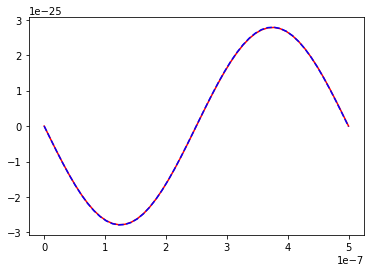

In [15]:
plt.plot(tt,p_t,'r')
plt.plot(tt,p_t_Schrodinger,'b--')

The classical and quantum trajectories are undistinguishable, as should be for the harmonic oscillator.